In [114]:

# Dependencies and Setup
import uszipcode
from uszipcode import SearchEngine
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import requests
import json
from census import Census
from us import states
from cmaps import rmaps
api_key = '10da8c6fe34292f1c2578a5f43cddc1fe8a98a25'


ModuleNotFoundError: No module named 'cmaps'

In [58]:

c = Census(
    api_key,
    year = 2020
)
census_data_counties = c.acs5.get(
    ("NAME", "B19013_001E", "B01003_001E", "B01002_001E", "B19301_001E", "B17001_002E"),
    {'for': 'county:*', 'in': 'state:53'}
)

# Convert the county data to a DataFrame
county_pd = pd.DataFrame(census_data_counties)

# Column renaming
county_pd = county_pd.rename(
    columns={
        "B01003_001E": "Population",
        "B01002_001E": "Median Age",
        "B19013_001E": "Household Income",
        "B19301_001E": "Per Capita Income",
        "B17001_002E": "Poverty Count",
        "NAME": "County",
        "state": "State Code",
        "county": "County Code"
    }
)
# Remove " County, Washington" from the county names
county_pd["County"] = county_pd["County"].str.replace(" County, Washington", "")
# Add a Poverty Rate column (Poverty Count / Population)
county_pd["Poverty Rate"] = 100 * county_pd["Poverty Count"].astype(int) / county_pd["Population"].astype(int)

# Configure the final DataFrame
county_pd = county_pd[
    [
        "County",
        "Population",
        "Median Age",
        "Household Income",
        "Per Capita Income",
        "Poverty Count",
        "Poverty Rate"
    ]
]



# Electric Data Population Set:

In [60]:
wa_data="C://Users//kayvb//OneDrive//Desktop//Electric_Vehicle_Population_Data.csv"
wa_df = pd.read_csv(wa_data)



In [61]:
wa_df.drop(['VIN (1-10)','Postal Code', 'Legislative District', 'Vehicle Location', '2020 Census Tract'], axis=1, inplace=True)

# Information About Data: 

In [63]:
#Setting our Data to only include Washington State
wa_count= wa_df[wa_df['State'] == 'WA']


In [64]:
wa_count.nunique()

County                                                   39
City                                                    456
State                                                     1
Model Year                                               22
Make                                                     36
Model                                                   126
Electric Vehicle Type                                     2
Clean Alternative Fuel Vehicle (CAFV) Eligibility         3
Electric Range                                          102
Base MSRP                                                31
DOL Vehicle ID                                       138464
Electric Utility                                         75
dtype: int64

In [65]:
vehicle_census = pd.merge(county_pd,wa_count)
vehicle_census.columns

Index(['County', 'Population', 'Median Age', 'Household Income',
       'Per Capita Income', 'Poverty Count', 'Poverty Rate', 'City', 'State',
       'Model Year', 'Make', 'Model', 'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range',
       'Base MSRP', 'DOL Vehicle ID', 'Electric Utility'],
      dtype='object')

In [66]:
vehicle_census.head()

,County,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,City,State,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,DOL Vehicle ID,Electric Utility
0,Adams,19702.0,28.0,51601.0,20592.0,4572.0,23.205766,Ritzville,WA,2021,FORD,MUSTANG MACH-E,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,182784948,BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...
1,Adams,19702.0,28.0,51601.0,20592.0,4572.0,23.205766,Lind,WA,2020,CHRYSLER,PACIFICA,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,32,0,172384866,AVISTA CORP
2,Adams,19702.0,28.0,51601.0,20592.0,4572.0,23.205766,Othello,WA,2021,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,150335993,BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...
3,Adams,19702.0,28.0,51601.0,20592.0,4572.0,23.205766,Ritzville,WA,2014,FORD,C-MAX,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,19,0,195909430,BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...
4,Adams,19702.0,28.0,51601.0,20592.0,4572.0,23.205766,Othello,WA,2023,FORD,MUSTANG MACH-E,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,229613002,AVISTA CORP


In [67]:
vehicle_census.shape

(138464, 18)

In [68]:
#Total Population
wa_count.columns

Index(['County', 'City', 'State', 'Model Year', 'Make', 'Model',
       'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range',
       'Base MSRP', 'DOL Vehicle ID', 'Electric Utility'],
      dtype='object')

In [77]:
grouped_data = vehicle_census.groupby('County')

# Calculate population statistics for each county
county_population_stats = grouped_data['Population'].agg(['sum', 'mean', 'median', 'max', 'min'])

# Rename the columns for clarity
county_population_stats = county_population_stats.rename(columns={
    'sum': 'Total Population',
    'mean': 'Mean Population',
    'median': 'Median Population',
    'max': 'Max Population',
    'min': 'Min Population'
})

# Display the population statistics for each county
print(county_population_stats)



              Total Population  Mean Population  Median Population  \
County                                                               
Adams             7.880800e+05          19702.0            19702.0   
Asotin            1.267616e+06          22636.0            22636.0   
Benton            3.420184e+08         200715.0           200715.0   
Chelan            6.331538e+07          76653.0            76653.0   
Clallam           6.516266e+07          76482.0            76482.0   
Clark             3.962111e+09         481950.0           481950.0   
Columbia          6.840800e+04           4024.0             4024.0   
Cowlitz           7.512051e+07         108399.0           108399.0   
Douglas           1.156544e+07          42520.0            42520.0   
Ferry             1.987180e+05           7643.0             7643.0   
Franklin          4.140700e+07          93681.0            93681.0   
Garfield          9.032000e+03           2258.0             2258.0   
Grant             4.

In [70]:
wa_count= wa_df[wa_df['State'] == 'WA']

In [71]:
make_county = wa_df.groupby('County')['Electric Vehicle Type'].value_counts()

In [72]:
make_county

County       Electric Vehicle Type                 
Adams        Battery Electric Vehicle (BEV)             29
             Plug-in Hybrid Electric Vehicle (PHEV)     12
Alameda      Battery Electric Vehicle (BEV)              3
Alexandria   Battery Electric Vehicle (BEV)              2
             Plug-in Hybrid Electric Vehicle (PHEV)      2
                                                      ... 
Wilson       Plug-in Hybrid Electric Vehicle (PHEV)      1
Yakima       Battery Electric Vehicle (BEV)            505
             Plug-in Hybrid Electric Vehicle (PHEV)    254
Yavapai      Battery Electric Vehicle (BEV)              1
Yellowstone  Plug-in Hybrid Electric Vehicle (PHEV)      1
Name: count, Length: 247, dtype: int64

In [78]:
vehicle_census_sorted_by_population = vehicle_census.sort_values(by='Population', ascending=False)

In [79]:
vehicle_census_sorted_by_population

,County,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,City,State,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,DOL Vehicle ID,Electric Utility
69232,King,2225064.0,37.0,99158.0,55374.0,184895.0,8.309649,Bellevue,WA,2014,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,0,148970398,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA)
59008,King,2225064.0,37.0,99158.0,55374.0,184895.0,8.309649,Seattle,WA,2021,BMW,X3,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,17,0,135248326,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA)
59016,King,2225064.0,37.0,99158.0,55374.0,184895.0,8.309649,Auburn,WA,2023,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,240089174,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA)
59015,King,2225064.0,37.0,99158.0,55374.0,184895.0,8.309649,Federal Way,WA,2021,FORD,MUSTANG MACH-E,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,193539636,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA)
59014,King,2225064.0,37.0,99158.0,55374.0,184895.0,8.309649,Kirkland,WA,2020,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,289,0,7905789,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11699,Columbia,4024.0,49.0,61779.0,38606.0,270.0,6.709742,Dayton,WA,2023,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,228284864,PACIFICORP
13151,Garfield,2258.0,49.7,56923.0,28933.0,186.0,8.237378,Pomeroy,WA,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215,0,211461134,PACIFICORP
13149,Garfield,2258.0,49.7,56923.0,28933.0,186.0,8.237378,Pomeroy,WA,2014,FORD,C-MAX,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,19,0,342528266,PACIFICORP
13150,Garfield,2258.0,49.7,56923.0,28933.0,186.0,8.237378,Pomeroy,WA,2021,TOYOTA,RAV4 PRIME,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,42,0,161341925,PACIFICORP


In [94]:

grouped_data = vehicle_census.groupby(['Model Year', 'Electric Range'])['County']


In [98]:
specific_counties = ['Snohomish', 'King']  # You can add more counties to this list

# Filter the DataFrame for the specific counties
cars_in_counties = vehicle_census[vehicle_census['County'].isin(specific_counties)]

# Display the DataFrame with cars in the specific counties
cars_in_counties

,County,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,City,State,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,DOL Vehicle ID,Electric Utility
15598,King,2225064.0,37.0,99158.0,55374.0,184895.0,8.309649,Seattle,WA,2020,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,293,0,8781552,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA)
15599,King,2225064.0,37.0,99158.0,55374.0,184895.0,8.309649,Seattle,WA,2017,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,107,0,199305298,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA)
15600,King,2225064.0,37.0,99158.0,55374.0,184895.0,8.309649,Burien,WA,2018,BMW,I3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,114,0,289807101,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA)
15601,King,2225064.0,37.0,99158.0,55374.0,184895.0,8.309649,Seattle,WA,2017,BMW,I3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,81,0,204770275,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA)
15602,King,2225064.0,37.0,99158.0,55374.0,184895.0,8.309649,Duvall,WA,2020,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,289,0,2246226,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121795,Snohomish,811572.0,38.0,89273.0,41126.0,57690.0,7.108427,Edmonds,WA,2023,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,240176380,PUGET SOUND ENERGY INC
121796,Snohomish,811572.0,38.0,89273.0,41126.0,57690.0,7.108427,Mountlake Terrace,WA,2022,KIA,EV6,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,202257751,PUGET SOUND ENERGY INC
121797,Snohomish,811572.0,38.0,89273.0,41126.0,57690.0,7.108427,Lake Stevens,WA,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220,0,179572249,PUGET SOUND ENERGY INC
121798,Snohomish,811572.0,38.0,89273.0,41126.0,57690.0,7.108427,Mountlake Terrace,WA,2013,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,75,0,110584799,PUGET SOUND ENERGY INC


Correlation coefficient: -0.40443418196754005


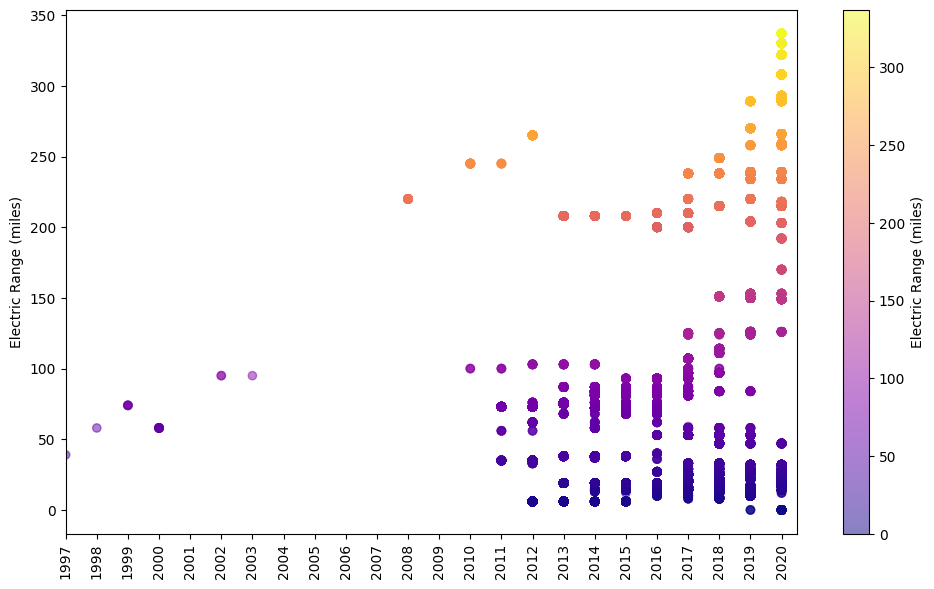

In [123]:
# Assuming you have the 'vehicle_census' DataFrame with the necessary data.

# Filter out rows with missing 'Electric Range' values and limit to 2020 Model Year
vehicle_census_filtered = vehicle_census.dropna(subset=['Electric Range'])


# Convert 'Model Year' to numeric (in case it's stored as a string)
vehicle_census_filtered['Model Year'] = pd.to_numeric(vehicle_census_filtered['Model Year'])

correlation = vehicle_census_filtered['Model Year'].corr(vehicle_census_filtered['Electric Range'])
print(f"Correlation coefficient: {correlation}")
# Set colors based on electric range using a colormap
colors = plt.colormaps.get_cmap('plasma')  # Choose a colormap (e.g., 'coolwarm', 'viridis', 'plasma', etc.)

# Create a scatter plot with custom colors
plt.figure(figsize=(10, 6))
plt.scatter(vehicle_census_filtered['Model Year'], vehicle_census_filtered['Electric Range'], c=vehicle_census_filtered['Electric Range'], cmap=colors, alpha=0.5)
plt.colorbar(label='Electric Range (miles)')  # Add a colorbar to show the range values
plt.xlim(1997, 2020.5)  # Adjust the x-axis limits for better visualization
plt.xticks(np.arange(1997, 2021, 1),rotation='vertical')  # Set x-axis ticks to only show 2020
plt.ylabel('Electric Range (miles)')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [140]:
urban_counties=
rural_counties


<bound method IndexOpsMixin.nunique of 0         Ritzville
1              Lind
2           Othello
3         Ritzville
4           Othello
            ...    
138459      Pullman
138460      Pullman
138461      Rosalia
138462      Pullman
138463       Colfax
Name: City, Length: 138464, dtype: object>

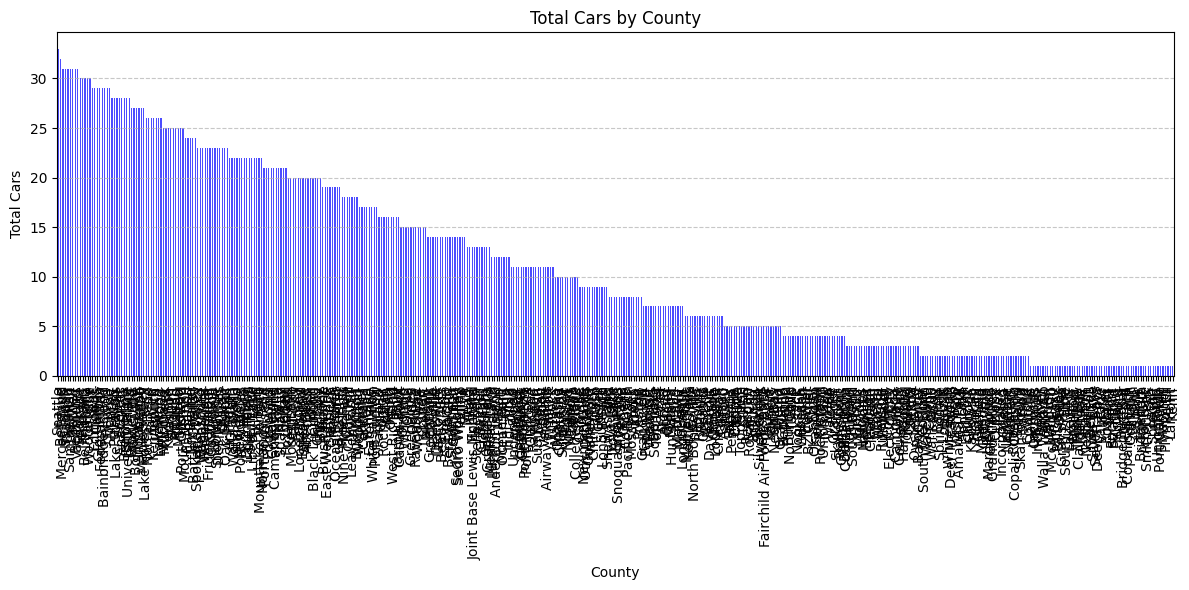

In [136]:
# Group the data by county and calculate the total number of cars in each county
total_cars_by_county = vehicle_census.groupby('City')['Make'].nunique()

# Calculate the correlation between the total cars and electric range for each county
total_cars_by_county = total_cars_by_county.sort_values(ascending=False)

# Plot the bar graph
plt.figure(figsize=(12, 6))
total_cars_by_county.plot(kind='bar', color='b', alpha=0.7)
plt.xlabel('County')
plt.ylabel('Total Cars')
plt.title('Total Cars by County')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()